# A model for chlamydia surveillance data

We propose a three-compartment model of chlamydia infection, testing and screening in a closed population, as illustrated below. Uninfected individuals (U) become infected with a constant incidence, and move to either the asymptomatic-infected (A) or symptomatic-infected (S) pool. Asymptomatic-infected individuals may leave A and return to U by spontaneous clearance of their infection or by detection and treatment under a screening programme. Symptomatic individuals may similarly be screened, but will also seek treatment at a rate which is typically much higher than the rates of spontaneous clearance or screening. 

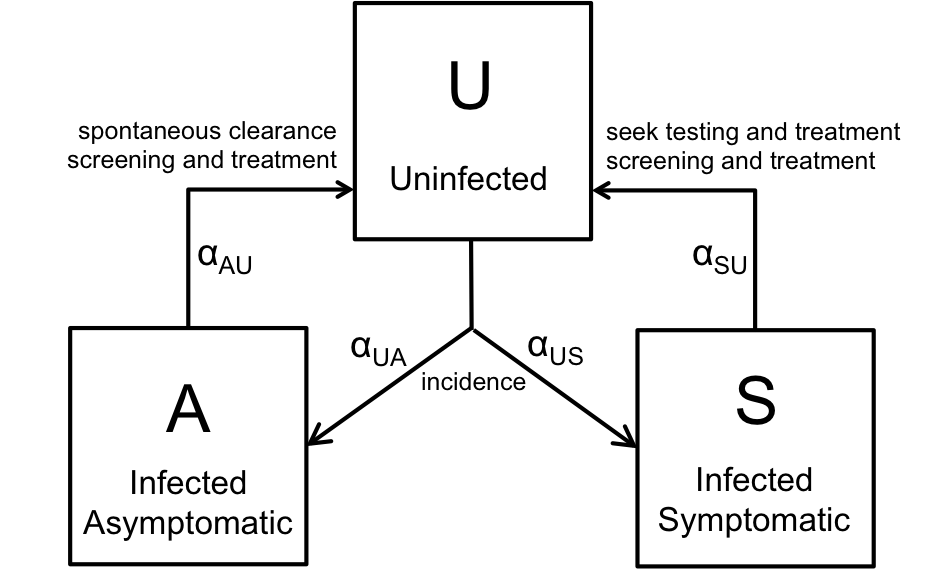

In [1]:
from IPython.display import Image
Image(filename="figures/3_comp.png", width=500)

This dynamic model has a steady-state solution which depends on the transition rates $\alpha_{UA}$, $\alpha_{AU}$, $\alpha_{US}$ and $\alpha_{SU}$:

In [2]:
import sympy as sym
from sympy import *
A, U, S = symbols("A U S")
alpha_UA, alpha_AU, alpha_US, alpha_SU  = symbols("alpha_UA alpha_AU alpha_US alpha_SU")

model_dyn = [
    alpha_UA*U - alpha_AU*A,
    alpha_AU*A + alpha_SU*S - (alpha_UA + alpha_US)*U,
    alpha_US*U - alpha_SU*S,
    A + U + S - 1 # this equation sets the total population size to 1
    ]

# steady-state solution
sol_dyn = solve(model_dyn, A, U, S)

# functions for calculating the proportion of the population in each compartment at 
# steady state, given transition rates between compartments
dyn_fun = lambdify((alpha_UA, alpha_AU, alpha_US, alpha_SU), sol_dyn[A] + sol_dyn[S])
U_fun = lambdify((alpha_UA, alpha_AU, alpha_US, alpha_SU), sol_dyn[U])
A_fun = lambdify((alpha_UA, alpha_AU, alpha_US, alpha_SU), sol_dyn[A])
S_fun = lambdify((alpha_UA, alpha_AU, alpha_US, alpha_SU), sol_dyn[S])

sol_dyn

{S: alpha_AU*alpha_US/(alpha_AU*alpha_US + alpha_SU*(alpha_AU + alpha_UA)),
 U: alpha_AU*alpha_SU/(alpha_AU*alpha_US + alpha_SU*(alpha_AU + alpha_UA)),
 A: alpha_SU*alpha_UA/(alpha_AU*alpha_US + alpha_SU*(alpha_AU + alpha_UA))}

The transition rates are functions of parameters describing behaviour and the natural history of infection:

$$
\begin{align}
\alpha_{UA} &= \mbox{incidence} \times (1 - p_{symptomatic}) \\
\alpha_{AU} &= \mbox{rate of spontaneous clearance} + \mbox{rate of screening} \times p_{true positive} \\
\alpha_{US} &= \mbox{incidence} \times p_{symptomatic} \\
\alpha_{SU} &= (\mbox{rate of screening} + \mbox{rate of symptomatic testing}) \times p_{true positive}
\end{align}
$$

Assuming all tests conducted are included in the surveillance data, the number of tests reported per unit time will be:

$$
\mbox{rate of testing} = \mbox{rate of screening} + S \times \mbox{rate of symptomatic testing}
$$

And the number of diagnoses per unit time will be:

\begin{multline*}
\mbox{rate of new diagnoses} = (A+S) \times (\mbox{rate of screening} \times p_{true positive}) \\
+ (U \times \mbox{rate of screening} \times p_{false positive}) \\
+ (S \times \mbox{rate of symptomatic testing} \times p_{truepositive})
\end{multline*}

Let's assume (based on mean sampled values for men; see Table 2 of main text) that:

* 51.0% of incident infections are asymptomatic.
* Infections (whether symptomatic or not) clear spontaneously or through background antibiotic use at a rate 0.47 per year.
* Symptomatic cases seek and obtain testing and treatment at a rate 14.4 per year.
* 97.1% of tests in infected individuals return a positive result. 
* 0.314% of tests in uninfected individuals return a positive result.

In [3]:
p_asymp = 0.510
sc = 0.47
att_symp = 14.4
p_true_pos = 0.971
p_false_pos = 0.00314

It is then possible to calculate the steady-state proportion of the population in each compartment given the rate of screening and incidence, and from these proportions to calculate the total prevalence, and the rates of new tests and diagnoses.

In [4]:
%matplotlib inline
from numpy import *
import matplotlib.pyplot as plt

inc = linspace(0, 0.5, 101) # incidence
scr = linspace(0, 0.5, 101) # screening
inc,scr = meshgrid(inc, scr)

# proportion of population in each compartment
ZU = U_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), scr*p_true_pos + att_symp*p_true_pos)
ZA = A_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), scr*p_true_pos + att_symp*p_true_pos)
ZS = S_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), scr*p_true_pos + att_symp*p_true_pos)

Zprev = 1 - ZU
Ztest = scr + ZS*att_symp
Zdiag = (ZA+ZS)*scr*p_true_pos + ZU*scr*p_false_pos + ZS*att_symp*p_true_pos

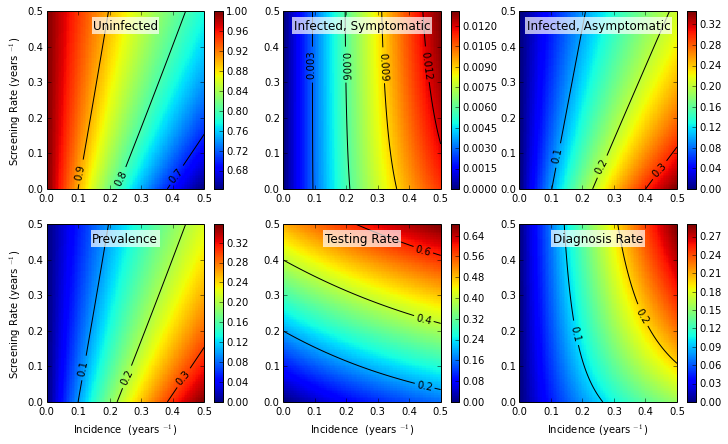

In [5]:
fig = plt.figure(figsize = (12, 7))

ax1 = fig.add_subplot(231)
p = ax1.pcolor(inc,scr, ZU)
c = ax1.contour(inc,scr, ZU, [0.6,0.7,0.8,0.9], colors=['k','k','k','k'])
plt.clabel(c, manual = [(0.1,0.05), (0.2,0.05), (0.4,0.05)], fmt='%1.1f')
cb = fig.colorbar(p, ax=ax1)
#ax1.set_xlabel('Incidence')
ax1.set_ylabel('Screening Rate (years $^{-1}$)')
t = ax1.text(0.25, 0.45, 'Uninfected', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax1.set_ylim(0, 0.5)
ax1.set_xlim(0, 0.5)

ax2 = fig.add_subplot(232)
p = ax2.pcolor(inc,scr, ZS)
c = ax2.contour(inc,scr, ZS, (0.003,0.006,0.009,0.012), colors='k', manual=True)
plt.clabel(c, manual = [(0.1,0.35), (0.2,0.35), (0.35,0.35), (0.45,0.35)])
cb = fig.colorbar(p, ax=ax2)
t = ax2.text(0.25, 0.45, 'Infected, Symptomatic', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax2.set_ylim(0, 0.5)
ax2.set_xlim(0, 0.5)

ax3 = fig.add_subplot(233)
p = ax3.pcolor(inc,scr, ZA)
c = ax3.contour(inc,scr, ZA, (0.1,0.2,0.3), colors='k')
plt.clabel(c, manual = [(0.1,0.1), (0.2,0.1), (0.4,0.1)], fmt='%1.1f')
cb = fig.colorbar(p, ax=ax3)
t = ax3.text(0.25, 0.45, 'Infected, Asymptomatic', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax3.set_ylim(0, 0.5)
ax3.set_xlim(0, 0.5)

ax4 = fig.add_subplot(234)
p = ax4.pcolor(inc,scr, Zprev)
c = ax4.contour(inc,scr, Zprev, (0.1,0.2,0.3), colors='k')
plt.clabel(c, manual = [(0.1,0.1), (0.2,0.1), (0.4,0.1)], fmt='%1.1f')
cb = fig.colorbar(p, ax=ax4)
ax4.set_xlabel('Incidence  (years $^{-1}$)')
ax4.set_ylabel('Screening Rate (years $^{-1}$)')
t = ax4.text(0.25, 0.45, 'Prevalence', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax4.set_ylim(0, 0.5)
ax4.set_xlim(0, 0.5)

ax5 = fig.add_subplot(235)
p = ax5.pcolor(inc,scr, Ztest)
c = ax5.contour(inc,scr, Ztest, (0.2,0.4,0.6), colors='k')
plt.clabel(c, manual = [(0.45,0.05), (0.45,0.25), (0.45,0.45)], fmt='%1.1f')
cb = fig.colorbar(p, ax=ax5)
ax5.set_xlabel('Incidence  (years $^{-1}$)')
t = ax5.text(0.25, 0.45, 'Testing Rate', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax5.set_ylim(0, 0.5)
ax5.set_xlim(0, 0.5)

ax6 = fig.add_subplot(236)
p = ax6.pcolor(inc,scr, Zdiag)
c = ax6.contour(inc,scr, Zdiag, (0.1,0.2), colors='k')
plt.clabel(c, manual = [(0.2,0.2), (0.4,0.25)], fmt='%1.1f')
cb = fig.colorbar(p, ax=ax6)
ax6.set_xlabel('Incidence (years $^{-1}$)')
t = ax6.text(0.25, 0.45, 'Diagnosis Rate', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax6.set_ylim(0, 0.5)
ax6.set_xlim(0, 0.5)

plt.show()   

From the figures, it is clear that a particular pair of observed testing and diagnosis rates corresponds to a single point in the (incidence, screening rate) plane, which in turn corresponds to a particular prevalence. Note, however, that this mapping depends on the parameter values which have been assumed.

We also produce the same plot, focussing on the lower part of the incidence range:

In [6]:
inc = linspace(0, 0.1, 101) # incidence - different range
scr = linspace(0, 0.5, 101) # screening
inc,scr = meshgrid(inc, scr)

# proportion of population in each compartment
ZU = U_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), scr*p_true_pos + att_symp*p_true_pos)
ZA = A_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), scr*p_true_pos + att_symp*p_true_pos)
ZS = S_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), scr*p_true_pos + att_symp*p_true_pos)

Zprev = 1 - ZU
Ztest = scr + ZS*att_symp
Zdiag = (ZA+ZS)*scr*p_true_pos + ZU*scr*p_false_pos + ZS*att_symp*p_true_pos

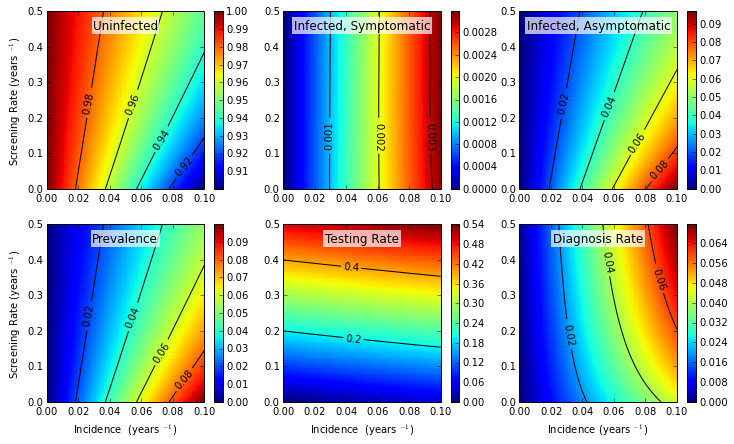

In [7]:
fig = plt.figure(figsize = (12, 7))

ax1 = fig.add_subplot(231)
p = ax1.pcolor(inc,scr, ZU)
c = ax1.contour(inc,scr, ZU, [0.92,0.94,0.96,0.98], colors=['k','k','k','k'])
plt.clabel(c, manual = [(0.02,0.25), (0.05,0.25), (0.07,0.15), (0.09,0.05)], fmt='%1.2f')
cb = fig.colorbar(p, ax=ax1)
#ax1.set_xlabel('Incidence')
ax1.set_ylabel('Screening Rate (years $^{-1}$)')
t = ax1.text(0.05, 0.45, 'Uninfected', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax1.set_ylim(0, 0.5)
ax1.set_xlim(0, 0.1)

ax2 = fig.add_subplot(232)
p = ax2.pcolor(inc,scr, ZS)
c = ax2.contour(inc,scr, ZS, (0.001,0.002,0.003), colors='k', manual=True)
plt.clabel(c, manual = [(0.03,0.15), (0.06,0.15), (0.09,0.15)], fmt='%1.3f')
cb = fig.colorbar(p, ax=ax2)
t = ax2.text(0.05, 0.45, 'Infected, Symptomatic', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax2.set_ylim(0, 0.5)
ax2.set_xlim(0, 0.1)

ax3 = fig.add_subplot(233)
p = ax3.pcolor(inc,scr, ZA)
c = ax3.contour(inc,scr, ZA, (0.02,0.04,0.06,0.08), colors='k')
plt.clabel(c, manual = [(0.02,0.25), (0.05,0.25), (0.07,0.15), (0.09,0.05)], fmt='%1.2f')
cb = fig.colorbar(p, ax=ax3)
t = ax3.text(0.05, 0.45, 'Infected, Asymptomatic', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax3.set_ylim(0, 0.5)
ax3.set_xlim(0, 0.1)

ax4 = fig.add_subplot(234)
p = ax4.pcolor(inc,scr, Zprev)
c = ax4.contour(inc,scr, Zprev, (0.02,0.04,0.06,0.08), colors='k')
plt.clabel(c, manual = [(0.02,0.25), (0.05,0.25), (0.07,0.15), (0.09, 0.05)], fmt='%1.2f')
cb = fig.colorbar(p, ax=ax4)
ax4.set_xlabel('Incidence  (years $^{-1}$)')
ax4.set_ylabel('Screening Rate (years $^{-1}$)')
t = ax4.text(0.05, 0.45, 'Prevalence', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax4.set_ylim(0, 0.5)
ax4.set_xlim(0, 0.1)

ax5 = fig.add_subplot(235)
p = ax5.pcolor(inc,scr, Ztest)
c = ax5.contour(inc,scr, Ztest, (0.2,0.4), colors='k')
plt.clabel(c, manual = [(0.045,0.2), (0.045,0.5)], fmt='%1.1f')
cb = fig.colorbar(p, ax=ax5)
ax5.set_xlabel('Incidence  (years $^{-1}$)')
t = ax5.text(0.05, 0.45, 'Testing Rate', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax5.set_ylim(0, 0.5)
ax5.set_xlim(0, 0.1)

ax6 = fig.add_subplot(236)
p = ax6.pcolor(inc,scr, Zdiag)
c = ax6.contour(inc,scr, Zdiag, (0.02,0.04,0.06), colors='k')
plt.clabel(c, manual = [(0.04,0.2), (0.06,0.4), (0.09,0.35)], fmt='%1.2f')
cb = fig.colorbar(p, ax=ax6)
ax6.set_xlabel('Incidence (years $^{-1}$)')
t = ax6.text(0.05, 0.45, 'Diagnosis Rate', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax6.set_ylim(0, 0.5)
ax6.set_xlim(0, 0.1)

plt.show()   

## Steady-state assumption

In using the model to interpret testing and diagnosis data, we assume the system is at steady state. We investigate to what extent this assumption is valid by perturbing the system and observing the return to equilibrium.

First, we use the national coverage and diagnoses per capita in men in the years 2012 - 2015. The analysis proceeds as follows:

1. Begin by estimating the steady state in 2012, using 2012 data.
2. Assuming a (potentially different) steady state in 2013, estimate incidence and screening rate in 2013.
3. Starting at the 2012 steady state, simulate the evolution of the system for one year with 2013 incidence and screening figures. Compare the prevalence after one year with the steady-state prevalence estimated for 2013 from that year's surveillance data, to see how closely they agree.
4. Repeat steps 2 and 3 for 2014 and 2015, each time starting the system in the state it had reached at the end of the previous one-year period.

The results of the simulations are then plotted.

In [8]:
from scipy.optimize import fsolve

tsym, dsym, ssym, test_sym = symbols('tsym dsym ssym test_sym')

model_test_diag = [
    tsym - ( ssym + (1 - A - U)*test_sym ),
    dsym - ( A*ssym*p_true_pos + U*ssym*p_false_pos + (1 - A - U)*test_sym*p_true_pos )
    ]

sol_test_diag = solve(model_test_diag, tsym, dsym)
test_fun = lambdify((A, U, ssym, test_sym), sol_test_diag[tsym])
diag_fun = lambdify((A, U, ssym, test_sym), sol_test_diag[dsym])

def test_diag_fun(parms):
    # parms = (incidence, screening rate)
    inc = parms[0]
    scr = parms[1]
    
    A = A_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1 - p_asymp), scr*p_true_pos + att_symp*p_true_pos)
    U = U_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1 - p_asymp), scr*p_true_pos + att_symp*p_true_pos)
    return [test_fun(A, U, scr, att_symp), diag_fun(A, U, scr, att_symp)]


# set up a function to simulate system dynamics when perturbed from steady state
from scipy.integrate import odeint

def dydt(y, t, parms):
    return([
    parms[1]*y[1] + parms[3]*y[2] - (parms[0] + parms[2])*y[0],
    parms[0]*y[0] - parms[1]*y[1],
    parms[2]*y[0] - parms[3]*y[2]
    ])

In [9]:
# find steady state based on 2012 data

cov_2012 = 566908. / 3519015.
adpc_2012 = 48387. / 3519015.
[incsol, scrsol] = fsolve(
    lambda x: [test_diag_fun(x)[0] - cov_2012, test_diag_fun(x)[1] - adpc_2012], 
    [0.09, 0.25] 
    )

U_2012 = U_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )
A_2012 = A_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )
S_2012 = S_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )


# find incidence and screening based on 2013 data
cov_2013 = 531428. / 3519015.
adpc_2013 = 48825. / 3519015.
[incsol, scrsol] = fsolve(
    lambda x: [test_diag_fun(x)[0] - cov_2013, test_diag_fun(x)[1] - adpc_2013], 
    [0.09, 0.25] 
    )

# solve, 2012-2013
inc = incsol
scr = scrsol
parms = \
    [incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos]

sol_12_13 = odeint(dydt, 
       [U_2012,A_2012,S_2012], 
       linspace(0,10,1000), 
       args = (parms,)
      )

In [10]:
# incidence and screening based on 2014 data
cov_2014 = 493327. / 3500026.
adpc_2014 = 47437. / 3500026.
[incsol, scrsol] = fsolve(
    lambda x: [test_diag_fun(x)[0] - cov_2014, test_diag_fun(x)[1] - adpc_2014], 
    [0.09, 0.25] 
    )
inc = incsol
scr = scrsol
parms = \
    [incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos]

# solve, 2013-2014
sol_13_14 = odeint(dydt, 
       sol_12_13[999,:], 
       linspace(0,10,1000), 
       args = (parms,)
      )

In [11]:
# incidence and screening based on 2015 data
cov_2015 = 446279. / 3496125.
adpc_2015 = 44609. / 3496125.
[incsol, scrsol] = fsolve(
    lambda x: [test_diag_fun(x)[0] - cov_2015, test_diag_fun(x)[1] - adpc_2015], 
    [0.09, 0.25] 
    )
inc = incsol
scr = scrsol
parms = \
    [incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos]

# solve, 2013-2014
sol_14_15 = odeint(dydt, 
       sol_13_14[999,:], 
       linspace(0,10,1000), 
       args = (parms,)
      )

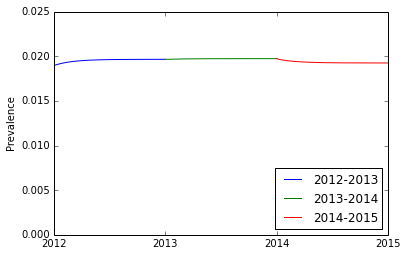

In [12]:
# plot solutions
plt.plot(linspace(2012,2013,1000), sol_12_13[:,1]+sol_12_13[:,2], label='2012-2013')
plt.plot(linspace(2013,2014,1000), sol_13_14[:,1]+sol_13_14[:,2], label='2013-2014')
plt.plot(linspace(2014,2015,1000), sol_14_15[:,1]+sol_14_15[:,2], label='2014-2015')
plt.ylim(0,0.025)
plt.ylabel('Prevalence')
plt.xticks([2012,2013,2014,2015], ['2012','2013','2014','2015'])
plt.legend(loc=4)

The plot shows that prevalence was very close to the steady state, with differences being very small compared to the uncertainty in prevalence estimates illustrated in the Figures in the main text.

To investigate the validity of the steady state assumption at a local level, we identified the local authorities with the largest changes in prevalence between 2012 and 2013:

|                  |Test rate   |(year$^{-1}$)|Diagnosis rate |(year$^{-1}$)|Prevalence   |              |
|------------------|------------|-------------|---------------|-------------|-------------|--------------|
|Year              |2012        | 2013        |2012           | 2013        |2012         | 2013         |
|North Lincolnshire|0.101       | 0.173       |0.022          | 0.011       |2.1%         | 3.9%         |
|Haringey          |0.267       | 0.191       |0.035          | 0.018       |4.2%         | 2.7%         |
|Dudley            |0.075       | 0.239       |0.020          | 0.006       |1.1%         | 2.4%         |


In [13]:
# North Lincolnshire
# find steady state based on 2012 data

cov_2012 = 0.100807801953
adpc_2012 = 0.0111652211547
[incsol, scrsol] = fsolve(
    lambda x: [test_diag_fun(x)[0] - cov_2012, test_diag_fun(x)[1] - adpc_2012], 
    [0.09, 0.25] 
    )

U_2012 = U_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )
A_2012 = A_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )
S_2012 = S_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )


# find incidence and screening based on 2013 data
cov_2013 = 0.173269822929
adpc_2013 = 0.0216211803756
[incsol, scrsol] = fsolve(
    lambda x: [test_diag_fun(x)[0] - cov_2013, test_diag_fun(x)[1] - adpc_2013], 
    [0.09, 0.25] 
    )

# solve, 2012-2013
inc = incsol
scr = scrsol
parms = \
    [incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos]

sol_n_lincs = odeint(dydt, 
       [U_2012,A_2012,S_2012], 
       linspace(0,10,1000), 
       args = (parms,)
      )


In [14]:
# Haringey
# find steady state based on 2012 data

cov_2012 = 0.267007002375
adpc_2012 = 0.0346976493046
[incsol, scrsol] = fsolve(
    lambda x: [test_diag_fun(x)[0] - cov_2012, test_diag_fun(x)[1] - adpc_2012], 
    [0.09, 0.25] 
    )

U_2012 = U_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )
A_2012 = A_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )
S_2012 = S_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )


# find incidence and screening based on 2013 data
cov_2013 = 0.190544970144
adpc_2013 = 0.0184872060681
[incsol, scrsol] = fsolve(
    lambda x: [test_diag_fun(x)[0] - cov_2013, test_diag_fun(x)[1] - adpc_2013], 
    [0.09, 0.25] 
    )

# solve, 2012-2013
inc = incsol
scr = scrsol
parms = \
    [incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos]

sol_haringey = odeint(dydt, 
       [U_2012,A_2012,S_2012], 
       linspace(0,10,1000), 
       args = (parms,)
      )


In [15]:
# Dudley
# find steady state based on 2012 data

cov_2012 = 0.0750667240187
adpc_2012 = 0.0057129570304
[incsol, scrsol] = fsolve(
    lambda x: [test_diag_fun(x)[0] - cov_2012, test_diag_fun(x)[1] - adpc_2012], 
    [0.09, 0.25] 
    )

U_2012 = U_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )
A_2012 = A_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )
S_2012 = S_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )


# find incidence and screening based on 2013 data
cov_2013 = 0.238873910562
adpc_2013 = 0.0199612670162
[incsol, scrsol] = fsolve(
    lambda x: [test_diag_fun(x)[0] - cov_2013, test_diag_fun(x)[1] - adpc_2013], 
    [0.09, 0.25] 
    )

# solve, 2012-2013
inc = incsol
scr = scrsol
parms = \
    [incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos]

sol_dudley = odeint(dydt, 
       [U_2012,A_2012,S_2012], 
       linspace(0,10,1000), 
       args = (parms,)
      )

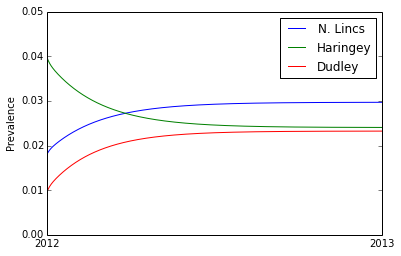

In [16]:
# plot solutions
plt.plot(linspace(2012,2013,1000), sol_n_lincs[:,1]+sol_n_lincs[:,2], label='N. Lincs')
plt.plot(linspace(2012,2013,1000), sol_haringey[:,1]+sol_haringey[:,2], label = 'Haringey')
plt.plot(linspace(2012,2013,1000), sol_dudley[:,1]+sol_dudley[:,2], label = 'Dudley')
plt.ylim(0,0.05)
plt.xlim(2012,2013)
plt.ylabel('Prevalence')
plt.xticks([2012,2013], ['2012','2013'])
plt.legend()

At local level changes in prevalence can be more pronounced than at national level, but even with the largest changes in prevalence the new steady state is reached after much less than a year.

## Different testing rates in different populations

We also investigate the sensitivity of the model to different testing rates in subpoulations with different prevalences. This analysis makes use of results reported in Woodhall _Sex. Transm. Infect._ **92**:21-227 (2016) for the proportion of 16-24-year-old men in Natsal-3 reporting different risk behaviours and chlamydia testing and diagnosis in the last year.

Taking each risk factor in turn, we estimate prevalence for each risk level and take the weighted average as an estimate of population prevalence. We also estimate prevalence from the proportion tested and and diagnosed in the whole population, for comparison.

In [17]:
# analysis by identified risk factors for prevalent infection: 
# age group, deprivation index and lifetime number of sexual partners
factors = ['Age group', 'Deprivation', 'Lifetime sexual partners']

# proportion of those surveyed reporting each risk factor level
n3_props =[[0.373, 0.627],[0.369,0.182,0.449],[0.527, 0.224, 0.249]]

# proportion reporting testing in the last year, by risk factor level
n3_test = [[0.404, 0.311],[0.345, 0.333, 0.352],[0.253,0.396,0.492]] 

# proportion reporting diagnosis in the last year, by risk factor level
n3_diag = [[0.404*0.047, 0.311*0.067],
           [0.345*0.052, 0.333*0.05, 0.352*0.065],
           [0.253*0.01,0.396*0.038,0.492*0.123]]

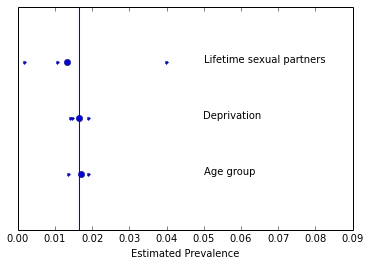

In [18]:
plt.figure(figsize=(6,4))

for j in xrange(len(n3_test)):
    wav = 0
    wav_pos = 0
    for i in xrange(len(n3_test[j])):
        cov = -log(1 - n3_test[j][i])
        adpc = - log(1 - n3_diag[j][i])
        [incsol, scrsol] = fsolve(
            lambda x: [test_diag_fun(x)[0] - cov, test_diag_fun(x)[1] - adpc], [0.09, 0.25] 
        )
        prev = 1 - U_fun(incsol*p_asymp, 
                         sc + scrsol*p_true_pos, 
                         incsol*(1-p_asymp), 
                         scrsol*p_true_pos + att_symp*p_true_pos
                        )
        plt.plot(prev, 2*(j+1), '.b')
        wav = wav + n3_props[j][i]*prev
        wav_pos = wav_pos + n3_props[j][i]*adpc/cov
        
    plt.plot(wav, 2*(j+1), 'ob')
    plt.text(0.05, 2*(j+1), factors[j])

# overall
cov = -log(1 - 0.346)
adpc = - log(1 - 0.02)
[incsol, scrsol] = fsolve(
    lambda x: [test_diag_fun(x)[0] - cov, test_diag_fun(x)[1] - adpc], [0.09, 0.25] 
)
prev = 1 - U_fun(
    incsol*p_asymp, sc + scrsol*p_true_pos, incsol*(1-p_asymp), scrsol*p_true_pos + att_symp*p_true_pos
    )

plt.plot([prev,prev],[0,100])

cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_ticks([])
plt.xlim([0,0.09])
plt.ylim([0,8])
plt.xlabel('Estimated Prevalence')

In this figure, small markers show risk-level-specific prevalence estimates and large markers show the weighted average of these level-specific estimates. The solid line shows prevalence estimated from aggregated testing and diagnosis (ie. not stratified by risk). It should be emphasised that due to limitations of the data, the analysis is intended as an illustration of the model's theoretical properties rather than an accurate estimate of prevalence in the different risk categories. The data from Natsal-3 is some of the best available, but nonetheless relies on participants' recall and accurate self-reporting. It was collected at a national level, and equivalent information is not available at a local level for incorporation into local-level prevalence estimates.

Although aggregating across the population does affect prevalence estimates, the differences are small compared with the 1-2% uncertainty which we found in our analyses of the surveillance data.